# Galaxy property distributions for all galaxies in the GZ Illustris dataset

## Module Imports

In [1]:
import SciServer.CasJobs as CasJobs # query with CasJobs
import SciServer.SciDrive           # read/write to/from SciDrive
import SciServer.LoginPortal

In [44]:
from pymongo import MongoClient
from bson.son import SON
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import astropy.io.fits as astrofits
from astropy.table import Table
import scipy
from scipy import interpolate
import pickle
import skimage.io 
import urllib3
import io
import requests
import gc # needed because the pandas plotting routines open too many files and cause crashes (maybe also mongo)
%matplotlib inline

## Initial Setup

### Control output verbosity and enable foratted prinding of data structures

In [3]:
verbose = True
if verbose :
    import pprint
    from IPython.core.display import display
    prettyPrinter = pprint.PrettyPrinter(indent=4)

### Credentials and static variables for Illustris Web Service
This API key should not require updating.

In [4]:
illustrisAPIKey="44ddc0a0574472a27514600007f1a6a1"
illustrisBaseUrl = 'http://www.illustris-project.org/api/'
illustrisHeaders = {"api-key":illustrisAPIKey}

### Utility function for performing queries of the Illustris web service

In [5]:
def illustrisGet(path, params = None, headers = None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)
    
    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()
    
    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    return r

### Credentials for SDSS CasJobs/SciServer interface
This key must be updated every time that the SciServer logout/login cycle occurs.

In [6]:
sciServerAuthToken = 'db3c963fdf1f42c79b490b9a54f58821'
SciServer.LoginPortal.setKeystoneToken(sciServerAuthToken)
userManager = SciServer.LoginPortal.getKeystoneUserWithToken(sciServerAuthToken)

### Variables pertaining to local  `mongodb` Galaxy Zoo classifications database

In [7]:
clientInstance = MongoClient()
database = clientInstance['test']
gzClassifications = database['galaxy_zoo_classifications']
gzSubjects = database['galaxy_zoo_subjects']
gzGroups = database['galaxy_zoo_groups']

### Variables that control serialization and loading of data extracted from the GZ mongo database

In [8]:
saveFullIllustrisMongoDataFrame = False
fullIllustrisMongoDataFramePath = '/Users/hughdickinson/Documents/Development/Sloan-Illustris-Comparison/data/FullIllustrisMongoDataFrame.pkl'

### Variables that control serialization and loading of data downloaded from the Illustris Web Service

In [9]:
saveFullIllustrisWebServiceDataFrame = False
fullIllustrisWebServiceDataFramePath = '/Users/hughdickinson/Documents/Development/Sloan-Illustris-Comparison/data/FullIllustrisWebServiceDataFrame.pkl'

### Variables that control serialization and loading of GZ-related data downloaded from the SDSS SkyServer

In [10]:
saveGalaxyZooSDSSDataFrame = False
galaxyZooSDSSDataFramePath = '/Users/hughdickinson/Documents/Development/Sloan-Illustris-Comparison/data/GalaxyZooSDSSDataFrame.pkl'

## Query `mongodb` database to retrieve subjects for the *illustris* survey

In [20]:
fullIllustrisMongoDataFrame = None

if saveFullIllustrisMongoDataFrame:
    fullIllustrisMongoData = list(gzSubjects.find({"metadata.survey": "illustris"}, 
                                                     {"metadata": 1, "state" : 1, "location": 1}))
    
    fullIllustrisMongoDataFrame = pd.DataFrame([ (
                fullIllustrisMongoDatum["metadata"]["subhalo_id"],
                fullIllustrisMongoDatum["metadata"]["priority"],
                fullIllustrisMongoDatum["state"],
                fullIllustrisMongoDatum["location"]["standard"],
                fullIllustrisMongoDatum["location"],
                fullIllustrisMongoDatum["metadata"]
            ) for fullIllustrisMongoDatum in fullIllustrisMongoData],
                                               columns=["subhalo_id",
                                                        "priority",
                                                        "state", 
                                                        "standard_location",
                                                        "all_location_data",
                                                        "all_metadata"]
                                              )
        
    fullIllustrisMongoDataFrame.to_pickle(fullIllustrisMongoDataFramePath)
else :
    pickleDataFile = open(fullIllustrisMongoDataFramePath, mode='rb')
    fullIllustrisMongoDataFrame = pickle.load(pickleDataFile) 
    pickleDataFile.close()
    
if verbose :
    display (fullIllustrisMongoDataFrame)

,subhalo_id,priority,state,standard_location,all_location_data,all_metadata
0,25,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 9.2236, 'subhalo_id': 25, 'pri..."
1,26,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 32.0453, 'subhalo_id': 26, 'pr..."
2,27,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 33.2924, 'subhalo_id': 27, 'pr..."
3,28,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 38.7566, 'subhalo_id': 28, 'pr..."
4,29,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 11.2812, 'subhalo_id': 29, 'pr..."
5,40,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 24.6295, 'subhalo_id': 40, 'pr..."
6,45,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 21.6691, 'subhalo_id': 45, 'pr..."
7,46,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 20.1613, 'subhalo_id': 46, 'pr..."
8,47,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 24.6924, 'subhalo_id': 47, 'pr..."
9,48,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 15.8815, 'subhalo_id': 48, 'pr..."


## Retrieve data for all *unique* database-retrieved subhalo IDs from the Illustris Web Service

In [12]:
fullIllustrisWebServiceDataFrame = None

if saveFullIllustrisWebServiceDataFrame :
    
    fullIllustrisWebServiceData = []
    
    illustris1SimulationUrl = [ entry['url'] for entry in illustrisGet(illustrisBaseUrl, headers=illustrisHeaders)['simulations'] if entry['name'] == 'Illustris-1'][0]
    illustris1SnapshotsUrl = illustrisGet(illustris1SimulationUrl, headers=illustrisHeaders)['snapshots']
    illustris1ZeroRedshiftSnapshotUrl = illustrisGet(illustris1SnapshotsUrl, headers=illustrisHeaders)[-1]['url']
    illustris1ZeroRedshiftSubHalosUrl = illustrisGet(illustris1ZeroRedshiftSnapshotUrl, headers=illustrisHeaders)['subhalos']

    if verbose :
        print('Base URL for Illustris-1 Simulation => {}'.format(illustris1SimulationUrl))
        print('Base URL for Illustris-1 Simulation Snapshots => {}'.format(illustris1SnapshotsUrl))
        print('Base URL for Illustris-1 Simulation Zero Redshift Snapshot => {}'.format(illustris1ZeroRedshiftSnapshotUrl))
        print('Base URL for Illustris-1 Simulation Zero Redshift Halos => {}\n'.format(illustris1ZeroRedshiftSubHalosUrl))

    requiredIllustrisHaloIds = fullIllustrisMongoDataFrame.groupby('subhalo_id').first().index.values
    
    for requiredIllustrisHaloIndex, requiredIllustrisHaloId in enumerate(requiredIllustrisHaloIds) :
        illustris1ZeroRedshiftSubHaloUrl = illustris1ZeroRedshiftSubHalosUrl + str(requiredIllustrisHaloId)
        fullIllustrisWebServiceData.append(illustrisGet(illustris1ZeroRedshiftSubHaloUrl, headers=illustrisHeaders))
        if requiredIllustrisHaloIndex % 100 == 0 :
            print ('Retrieved data for {} of {} halos...'.format(requiredIllustrisHaloIndex, len(requiredIllustrisHaloIds)))
    print ('Retrieved data for {} halos. Done.'.format(requiredIllustrisHaloIndex))
    
    fullIllustrisWebServiceDataFrame = pd.DataFrame(fullIllustrisWebServiceData)

    fullIllustrisWebServiceDataFrame.to_pickle(fullIllustrisWebServiceDataFramePath)
else :
    pickleDataFile = open(fullIllustrisWebServiceDataFramePath, mode='rb')
    fullIllustrisWebServiceDataFrame = pickle.load(pickleDataFile) 
    pickleDataFile.close()  

if verbose :
    display (fullIllustrisWebServiceDataFrame)

,bhmdot,cm_x,cm_y,cm_z,cutouts,desc_sfid,desc_snap,gasmetallicity,gasmetallicityhalfrad,gasmetallicitymaxrad,...,stellarphotometricsrad,supplementary_data,trees,vel_x,vel_y,vel_z,veldisp,vmax,vmaxrad,windmass
0,3.244590e-04,887.726,26311.20,18092.8,{'parent_halo': 'http://www.illustris-project....,-1,-1,0.009294,0.011018,0.007500,...,37.5182,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,25.2801,-217.0670,-82.0048,530.0060,857.801,499.4480,0.969088
1,1.260800e-06,184.273,24579.40,16865.0,{'parent_halo': 'http://www.illustris-project....,-1,-1,0.032274,0.033691,0.027029,...,17.3275,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,77.8400,599.7980,521.1330,261.1230,411.439,124.5930,0.235200
2,4.166120e-04,765.316,26758.30,17215.4,{'parent_halo': 'http://www.illustris-project....,-1,-1,0.040203,0.041272,0.038959,...,13.9054,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,309.6180,-565.6190,848.2140,264.0360,391.851,112.0800,0.001990
3,9.907680e-03,1204.510,26492.10,18221.3,{'parent_halo': 'http://www.illustris-project....,-1,-1,0.050764,0.059546,0.054003,...,19.5589,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,-331.8870,-870.3290,970.6010,227.3570,402.288,14.0941,0.000713
4,8.635300e-06,994.455,26623.40,17597.5,{'parent_halo': 'http://www.illustris-project....,-1,-1,0.023837,0.025455,0.025549,...,12.5330,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,62.9793,-1138.3000,636.5520,198.6760,355.815,7.0641,0.000000
5,8.833150e-03,1120.970,26604.80,18433.7,{'parent_halo': 'http://www.illustris-project....,-1,-1,0.054275,0.054488,0.054275,...,13.0157,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,-1208.7000,53.4307,-923.2020,170.2670,292.138,11.3179,0.000000
6,3.000000e-10,809.180,26290.80,18199.2,{'parent_halo': 'http://www.illustris-project....,-1,-1,0.012316,0.012227,0.012263,...,13.5273,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,191.5630,-439.4530,848.4350,204.6820,358.129,4.2489,0.000000
7,2.145650e-03,1425.950,26676.90,17298.5,{'parent_halo': 'http://www.illustris-project....,-1,-1,0.041462,0.044658,0.044915,...,10.2957,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,-272.7960,-414.9590,-106.8000,152.1130,281.529,7.9319,0.000315
8,0.000000e+00,1614.220,26050.70,19822.3,{'parent_halo': 'http://www.illustris-project....,-1,-1,0.000000,0.000000,0.000000,...,9.8320,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,526.0520,-616.9760,-434.3330,143.6210,286.451,9.5376,0.000000
9,0.000000e+00,827.883,26417.30,18222.8,{'parent_halo': 'http://www.illustris-project....,-1,-1,0.000000,0.000000,0.000000,...,11.2121,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,-518.2040,367.1850,-600.7420,192.8530,347.425,3.8281,0.000000


## Create a merged table with stellar masses for all halo IDs

In [24]:
illustrisStellarMassesFrame = fullIllustrisMongoDataFrame.merge(fullIllustrisWebServiceDataFrame, how='left', left_on='subhalo_id', right_on='id')
display(illustrisStellarMassesFrame)
print (illustrisStellarMassesFrame.columns.values)

,subhalo_id,priority,state,standard_location,all_location_data,all_metadata,bhmdot,cm_x,cm_y,cm_z,...,stellarphotometricsrad,supplementary_data,trees,vel_x,vel_y,vel_z,veldisp,vmax,vmaxrad,windmass
0,25,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 9.2236, 'subhalo_id': 25, 'pri...",0.000000e+00,1165.2100,25946.30,18561.600,...,8.7859,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,157.3450,-299.3540,-78.0878,127.1770,239.664,7.1610,0.000000
1,26,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 32.0453, 'subhalo_id': 26, 'pr...",1.060090e-04,1752.9000,26011.30,16643.300,...,7.9675,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,276.8820,-676.1580,516.4000,98.2799,198.033,10.5811,0.007268
2,27,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 33.2924, 'subhalo_id': 27, 'pr...",1.166630e-05,946.2470,25427.00,19288.200,...,7.2974,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,123.1300,-698.9820,-469.1830,99.7089,189.630,7.8489,0.022051
3,28,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 38.7566, 'subhalo_id': 28, 'pr...",1.041530e-05,427.2970,25238.30,16531.000,...,5.4734,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,298.8370,196.5820,717.4420,98.1325,175.218,21.8724,0.017302
4,29,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 11.2812, 'subhalo_id': 29, 'pr...",6.335200e-04,1538.7000,25444.90,18639.200,...,6.8014,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,-656.7020,276.1070,-298.5630,119.3960,229.778,3.3153,0.000253
5,40,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 24.6295, 'subhalo_id': 40, 'pr...",6.892390e-04,492.9790,27450.00,18068.700,...,6.6831,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,-172.7180,-128.7260,-692.7340,83.0752,161.920,13.0801,0.013223
6,45,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 21.6691, 'subhalo_id': 45, 'pr...",3.558900e-06,84.0242,25653.20,17701.500,...,4.9392,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,654.0550,-183.8580,-98.0915,89.8013,174.202,7.5317,0.000000
7,46,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 20.1613, 'subhalo_id': 46, 'pr...",3.675720e-04,468.9470,26181.40,18643.300,...,6.1630,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,173.8900,533.3390,-1307.3200,84.2916,160.870,8.1215,0.017452
8,47,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 24.6924, 'subhalo_id': 47, 'pr...",1.210880e-05,1368.5100,26298.70,20003.200,...,6.4015,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhalotree_mpb': 'http://www.illustris-projec...,-241.0960,-344.9360,-1114.2400,74.4913,142.018,15.8165,0.049134
9,48,fixed_view,complete,http://www.galaxyzoo.org.s3.amazonaws.com/subj...,{'thumbnail': 'http://www.galaxyzoo.org.s3.ama...,"{'radius_half': 15.8815, 'subhalo_id': 48, 'pr...",4.681800e-06,246.3650,25739.80,17773.600,...,5.6614,{'stellar_mocks': {'image_fof': 'http://www.il...,{'lhal

['subhalo_id' 'priority' 'state' 'standard_location' 'all_location_data'
 'all_metadata' 'bhmdot' 'cm_x' 'cm_y' 'cm_z' 'cutouts' 'desc_sfid'
 'desc_snap' 'gasmetallicity' 'gasmetallicityhalfrad'
 'gasmetallicitymaxrad' 'gasmetallicitysfr' 'gasmetallicitysfrweighted'
 'grnr' 'halfmassrad' 'halfmassrad_bhs' 'halfmassrad_dm' 'halfmassrad_gas'
 'halfmassrad_stars' 'id' 'len' 'len_bhs' 'len_dm' 'len_gas' 'len_stars'
 'mass' 'mass_bhs' 'mass_dm' 'mass_gas' 'mass_log_msun' 'mass_stars'
 'massinhalfrad' 'massinhalfrad_bhs' 'massinhalfrad_dm' 'massinhalfrad_gas'
 'massinhalfrad_stars' 'massinmaxrad' 'massinmaxrad_bhs' 'massinmaxrad_dm'
 'massinmaxrad_gas' 'massinmaxrad_stars' 'massinrad' 'massinrad_bhs'
 'massinrad_dm' 'massinrad_gas' 'massinrad_stars' 'meta' 'parent' 'pos_x'
 'pos_y' 'pos_z' 'primary_flag' 'prog_sfid' 'prog_snap' 'related' 'sfr'
 'sfrinhalfrad' 'sfrinmaxrad' 'sfrinrad' 'snap' 'spin_x' 'spin_y' 'spin_z'
 'starmetallicity' 'starmetallicityhalfrad' 'starmetallicitymaxrad'
 'stell

## Retrieve data for galaxies that were classified in Galaxy Zoo II from SciServer
**Notes**:
The SDSS database lists numerous measurements and derived estimates of the **apparent** magnitude for many galaxies in its dataset. Here the magnitude computed within the **petrosian** radius in each of the SDSS bands (u,g,r,i,z) is used.

Apparent magnitudes are converted to an **absolute** magnitude using the function `fCosmoAbsMag` provided by the SDSS database server. Default values are used for the cosmological description which correspoond with WMAP-5 values. In contrast, the Illustris simulation framework assumes the WMAP-9 values for its cosmological simulation. Since the selected galaxies all have 0.04 < z < 0.06 and the zero-redshift slice of the Illustris simulation was used, this discrepancy should not be problematic.

Vote fraction "probabilities" derived from Galaxy Zoo classifications are also extracted for all galaxies.

### Form a query that assembles data from various tables and views using database joins.

In [13]:
sdssDataBaseQuery = """SELECT spec.z, spec.zErr, spec.zWarning, 
spec.petroMag_u, spec.petroMag_g, spec.petroMag_r, spec.petroMag_i, spec.petroMag_z,   
dbo.fCosmoAbsMag(spec.petroMag_u,spec.z,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT) as absPetroMag_u,
dbo.fCosmoAbsMag(spec.petroMag_g,spec.z,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT) as absPetroMag_g,
dbo.fCosmoAbsMag(spec.petroMag_r,spec.z,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT) as absPetroMag_r,
dbo.fCosmoAbsMag(spec.petroMag_i,spec.z,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT) as absPetroMag_i,
dbo.fCosmoAbsMag(spec.petroMag_z,spec.z,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT) as absPetroMag_z,
zooSpecExtra.* FROM 
(
SELECT 
zoo.objid, zoo.dr7objid, zoo.ra, zoo.dec, zoo.rastring, zoo.decstring, zoo.nvote, 
zoo.p_el, zoo.p_cw, zoo.p_acw, zoo.p_edge, zoo.p_dk, zoo.p_mg, zoo.p_cs, zoo.p_el_debiased, zoo.p_cs_debiased,
spiral, zoo.elliptical, zoo.uncertain, specExtra.*
FROM zooSpec AS zoo 
LEFT JOIN 
galSpecExtra AS specExtra 
ON (specExtra.specObjID = zoo.specobjid) 
) 
AS zooSpecExtra 
LEFT JOIN
SpecPhoto AS spec 
ON 
(spec.specObjID = zooSpecExtra.specobjid) 
WHERE 
(spec.z > 0.04 AND spec.z < 0.06)
"""

### Execute the query using the SciServer CasJobs API
Note that **Data release 8** (`dr8`) must be specified as the query context, since extiates of stellar mass and star formation rate (retrieved from the `specExtra` table) do not exist for later releases.

The SciServer CasJobs API returns query results as a `pandas.DataFrame`, so no additional data manipulation is required once the API returns.

In [14]:
sdssDataBaseQueryResult = None
if saveGalaxyZooSDSSDataFrame :
    galaxyZooSDSSDataFrame = CasJobs.executeQuery(sdssDataBaseQuery, "dr8", token=sciServerAuthToken)
    galaxyZooSDSSDataFrame.to_pickle(galaxyZooSDSSDataFramePath)
else :
    pickleDataFile = open(galaxyZooSDSSDataFramePath, mode='rb')
    galaxyZooSDSSDataFrame = pickle.load(pickleDataFile) 
    pickleDataFile.close()
    
if verbose :
    display(galaxyZooSDSSDataFrame)
    prettyPrinter.pprint(galaxyZooSDSSDataFrame.columns.values)

,z,zErr,zWarning,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,absPetroMag_u,absPetroMag_g,...,specsfr_tot_p50,specsfr_tot_p84,specsfr_tot_p97p5,specsfr_tot_entropy,specsfr_fib_p2p5,specsfr_fib_p16,specsfr_fib_p50,specsfr_fib_p84,specsfr_fib_p97p5,specsfr_fib_entropy
0,0.047411,0.000012,0,18.54880,16.85961,16.03727,15.66638,15.34058,-18.064781,-19.753973,...,-12.396500,-11.543230,-10.932760,-6.278834,-14.620370,-13.665620,-12.396200,-11.487120,-10.768180,-6.340616
1,0.044529,0.000010,0,17.52230,16.12248,15.41560,15.00168,14.68496,-18.950456,-20.350277,...,-10.271360,-10.036990,-9.731944,-4.224891,-10.286080,-10.100000,-9.901456,-9.702222,-9.511468,-4.025777
2,0.055087,0.000016,0,18.07451,16.35515,15.49084,15.07580,14.80660,-18.877194,-20.596556,...,-12.211460,-11.382720,-10.742500,-6.322618,-14.495450,-13.382980,-12.090390,-11.256820,-10.676670,-6.299952
3,0.050788,0.000006,0,18.60359,17.40190,16.99499,16.64875,16.58631,-18.164804,-19.366495,...,-9.950209,-9.695161,-9.338000,-4.310218,-10.148950,-9.976995,-9.840381,-9.719561,-9.605693,-3.451127
4,0.054887,0.000014,0,18.22514,16.39491,15.48788,15.06513,14.75050,-18.718341,-20.548578,...,-12.542520,-11.728670,-11.066670,-6.224016,-14.650000,-13.682290,-12.499520,-11.655730,-11.041300,-6.244517
5,0.054096,0.000017,0,19.18540,17.50917,16.73115,16.36609,16.09742,-17.725289,-19.401514,...,-11.438510,-10.741670,-10.208330,-6.285340,-14.200000,-12.746810,-11.387040,-10.690370,-10.183330,-6.245118
6,0.059259,0.000012,0,18.44806,16.46276,15.58985,15.15435,14.82124,-18.668763,-20.654065,...,-12.457960,-11.523530,-10.758330,-6.382539,-14.715620,-13.727550,-12.492720,-11.624050,-10.865000,-6.324888
7,0.048742,0.000013,0,17.26015,15.53435,14.91835,14.61415,14.31575,-19.415700,-21.141508,...,-10.502740,-10.163860,-9.768749,-4.781360,-12.504550,-11.084400,-10.656200,-10.244840,-9.765517,-5.362657
8,0.054950,0.000013,0,18.10780,16.23346,15.34903,15.05192,14.60592,-18.838259,-20.712599,...,-11.950000,-11.190090,-10.626090,-6.268757,-14.519230,-13.291960,-11.943530,-11.025620,-10.351610,-6.431592
9,0.055170,0.000019,0,18.05796,16.62740,15.68419,15.05906,14.73201,-18.897153,-20.327711,...,-10.856710,-10.372560,-9.855769,-5.624289,-12.876920,-11.252990,-10.664100,-10.125770,-9.530000,-5.729641


array(['z', 'zErr', 'zWarning', 'petroMag_u', 'petroMag_g', 'petroMag_r',
       'petroMag_i', 'petroMag_z', 'absPetroMag_u', 'absPetroMag_g',
       'absPetroMag_r', 'absPetroMag_i', 'absPetroMag_z', 'dec',
       'decstring', 'dr7objid', 'dr8objid', 'ra', 'rastring', 'sample',
       't01_smooth_or_features_a01_smooth_count',
       't01_smooth_or_features_a01_smooth_debiased',
       't01_smooth_or_features_a01_smooth_flag',
       't01_smooth_or_features_a01_smooth_fraction',
       't01_smooth_or_features_a01_smooth_weight',
       't01_smooth_or_features_a01_smooth_weighted_fraction',
       't01_smooth_or_features_a02_features_or_disk_count',
       't01_smooth_or_features_a02_features_or_disk_debiased',
       't01_smooth_or_features_a02_features_or_disk_flag',
       't01_smooth_or_features_a02_features_or_disk_fraction',
       't01_smooth_or_features_a02_features_or_disk_weight',
       't01_smooth_or_features_a02_features_or_disk_weighted_fraction',
       't01_smooth_or_fe

## Manipulate the Illustris galaxy data as appropriate and compare with SDSS properties
### The distribution of stellar masses
Plot distributions of stellar masses for the full dataset, the subset of galaxies that are paused and various options for subsets to unpause.  

In [15]:
hubbleConstant = 0.74

10.7 20370
10.8 14940
10.9 10710
11 7080
11.1 4995
11.2 3630
11.3 2775
11.4 2400
11.5 1875
[1, 0, 2, 3, 4, 5, 6, 7, 8, 9, 10]


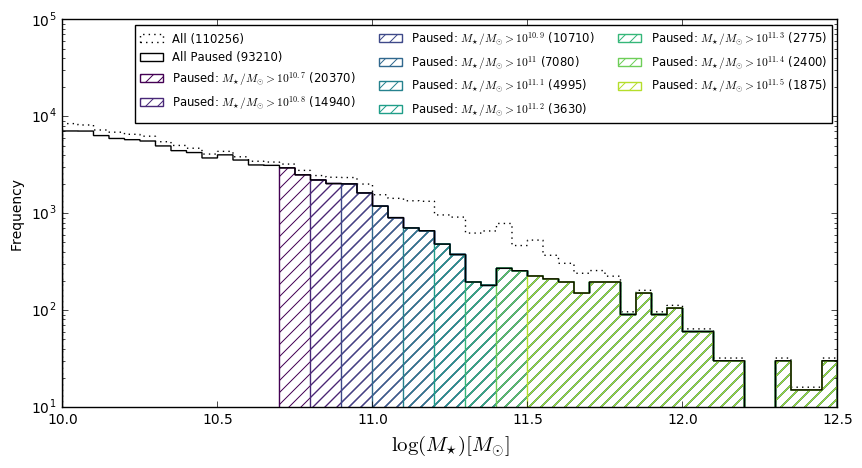

In [94]:
gc.collect()
illustrisStellarMassesFrame['logstellarmasses'] = np.log10(10**10*(illustrisStellarMassesFrame["mass_stars"]/hubbleConstant))
pausedIllustrisStellarMassesFrame = illustrisStellarMassesFrame[illustrisStellarMassesFrame['state'] == 'paused']

thresholds = (10.7, 10.8, 10.9, 11, 11.1, 11.2, 11.3, 11.4, 11.5)

thresholdedPausedIllustrisStellarMasses = { threshold : pausedIllustrisStellarMassesFrame[pausedIllustrisStellarMassesFrame['logstellarmasses'] > threshold]['logstellarmasses'] for threshold in thresholds}

unpauseSubsetFigure = plt.figure(figsize=(10,5))

unpauseSubsetAxes = pausedIllustrisStellarMassesFrame['logstellarmasses'].plot.hist(zorder=2, bins=50, histtype='step', logy=True, fill=False, color='k', range=(10, 12.5), label='All Paused ({})'.format(len(pausedIllustrisStellarMassesFrame.index)))
illustrisStellarMassesFrame['logstellarmasses'].plot.hist(zorder=1, bins=50, histtype='step', ls='dotted', logy=True, fill=False, color='k', range=(10, 12.5), label='All ({})'.format(len(illustrisStellarMassesFrame.index)))

cmap = matplotlib.cm.get_cmap('viridis')

for index, threshold in enumerate(sorted(thresholdedPausedIllustrisStellarMasses)) :
    print(threshold, len(thresholdedPausedIllustrisStellarMasses[threshold]))
    plotColor=cmap(index/len(thresholdedPausedIllustrisStellarMasses))
    thresholdedPausedIllustrisStellarMasses[threshold].plot.hist(zorder=1, fc=plotColor, ec=plotColor, bins=50, histtype='step', logy=True, fill=False, hatch='//', ax=unpauseSubsetAxes, range=(10, 12.5), label=r'Paused: $M_{}/M_{} > 10^{}{}{}$ ({})'.format(r'{\star}', r'{\odot}','{', threshold, '}', len(thresholdedPausedIllustrisStellarMasses[threshold])))

lines, labels = unpauseSubsetAxes.get_legend_handles_labels()
legendOrder=[1, 0]
legendOrder.extend([position for position in range(2, len(lines))])
print(legendOrder)

unpauseSubsetAxes.legend([lines[position] for position in legendOrder], [labels[position] for position in legendOrder], loc='best', fontsize='small', ncol=3)
unpauseSubsetAxes.set_ylim(10, 1e5)

plt.xlabel(r'$\log(M_{\star})[M_{\odot}]$', size=15)

### The distributions of absolute magnitudes in the SDSS (u, g, r, i, z) bands

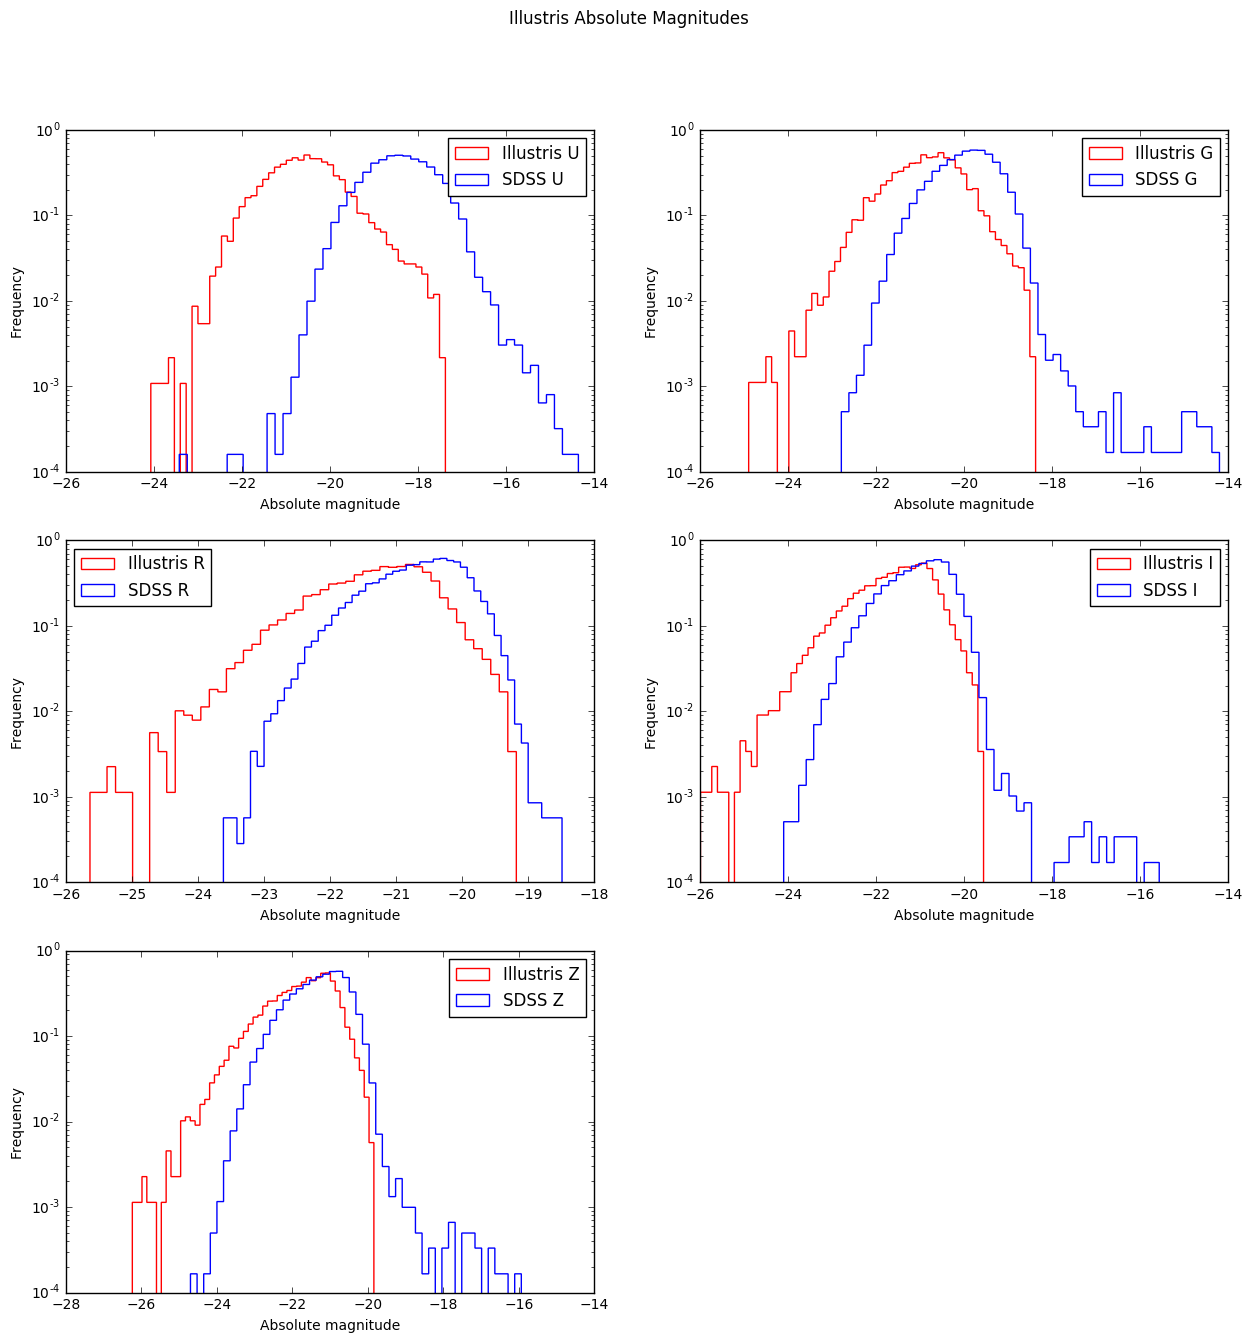

In [17]:
magLimits = {'u':22,
             'g':22.2,
             'r': 17.77,
             'i':21.3,
             'z':20.5}

illustrisAbsMagFigure = plt.figure(figsize=(15, 15))
illustrisAbsMagFigure.suptitle('Illustris Absolute Magnitudes', size=12)

for index, value in enumerate(['u','g','r','i','z']) :
    subplotAxis = plt.subplot(3, 2, index+1)
    fullIllustrisWebServiceDataFrame['stellarphotometrics_' + value].plot.hist(ax=subplotAxis, normed=True, bins=50, histtype='step', logy=True, fill=False, color='r')
    galaxyZooSDSSDataFrame[np.logical_and(galaxyZooSDSSDataFrame['absPetroMag_r'] > -9000, np.logical_and(galaxyZooSDSSDataFrame['petroMag_' + value] < magLimits[value], galaxyZooSDSSDataFrame['lgm_tot_p97p5'] > 10))][['absPetroMag_' + value]].plot.hist(normed=True, ax=subplotAxis, bins=50, histtype='step', logy=True, fill=False, label='SDSS ' + value.upper(), color='b')
    lines, labels = subplotAxis.get_legend_handles_labels()
    labels = ['Illustris ' + str(value.upper()), 'SDSS ' + str(value.upper())]
    subplotAxis.legend(lines[:2], labels[:2], loc='best')
    plt.xlabel("Absolute magnitude")